# Data Management Project 

Group member: Weichao Zhu, Xiancaozhi Yi, Weihao Zeng, Elvis Leng

## Attestation 

Each group member contribute meaningfully in this project. All members are highly anticipated in each part.

## Part 1
We are interested in the homicide rate in the United States. There are more than 30k people died from homicide every year in the States. The data we found has over 600,000 records and it contains information like victims and perpetrators' race, sex, age, and etc. This  set of data is very intriguing becuase with the current political environment and arguments about gun control, it is critical to understand how weapon use and homicide rate changes through out the years. 
This dataset includes murders from the FBI's Supplementary Homicide Report from 1976 to the 2014 and Freedom of Information Act data on more than 22,000 homicides that were not reported to the Justice Department. 
Becuase this dataset ranges from year 1980 to year 2014, we do expect that we will spend a huge amount of time to clean the dataset to filter out the unwanted or inaccurate information. The structure of the data set is perfect for us to use spark to analyze.
Here is the link of our dataset.
https://www.kaggle.com/murderaccountability/homicide-reports

Before we start wrangling the data, we used unix command to take an overview of the data.

In [ ]:
!unzip database.csv.zip

In [ ]:
!head database.csv | csvlook

In [ ]:
!wc -l database.csv

In [ ]:
!csvcut -n database.csv

In [1]:
!csvstat database.csv

Killed


### Concerns and interesting facts:
From the initial exploration, we find out that the state column has 51 unique values. We are not sure what the incident column means here. Although it must be something important, we are not going to research on it futher. The victim age has max amount of 998, which is not possible. The perpetrator age has values of 216,327 zeros, and a space. For the relationship, there are more acquaintance than stranger. 

### Theme:
We want to focus on the perpetrator side of the data. For example, what is the most frequently weapon the perpetrators use? How old is most of the perpetrators? Is the homiside increasing or decreasing over time? Does different age prefer different weapons and what do they use? Does male and female prefer different weapons? And so on.
### challenges:
The perpetrator age has a space as null value and also this attribute is identified as string instead of integer.

## Part 2

Now let's read the data using Spark.

In [1]:
import os

In [2]:
os.environ['SPARK_HOME'] = '/usr/local/lib/spark'

In [3]:
import findspark

In [4]:
findspark.init()

In [5]:
from pyspark import SparkContext

In [6]:
spark = SparkContext(appName='project')

In [7]:
spark

<SparkContext master=local[*] appName=project>

In [8]:
from pyspark import SQLContext

In [9]:
sqlc = SQLContext(spark)

In [10]:
sqlc

In [11]:
db = sqlc.read.csv('database.csv', header = True, inferSchema = True)

Now we have successfully loaded the data. First, let's take a look at the schema in Spark.

In [12]:
db.printSchema()

root
 |-- Record ID: integer (nullable = true)
 |-- Agency Code: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Agency Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Incident: integer (nullable = true)
 |-- Crime Type: string (nullable = true)
 |-- Crime Solved: string (nullable = true)
 |-- Victim Sex: string (nullable = true)
 |-- Victim Age: integer (nullable = true)
 |-- Victim Race: string (nullable = true)
 |-- Victim Ethnicity: string (nullable = true)
 |-- Perpetrator Sex: string (nullable = true)
 |-- Perpetrator Age: string (nullable = true)
 |-- Perpetrator Race: string (nullable = true)
 |-- Perpetrator Ethnicity: string (nullable = true)
 |-- Relationship: string (nullable = true)
 |-- Weapon: string (nullable = true)
 |-- Victim Count: integer (nullable = true)
 |-- Perpetrator Count: integer (nullable = true)
 |

From the above schema, we can see that the perpetrator age column is catigorized as string, which is not accurate. We are going to change the date type of this column to integer to benifit our future analysis. We ran into some problems when we were trying to change the data type, because there is a space as null value. Hence, we copied the column to another one and filtered out the row before we changed the data type to integer. 

First, we add a new coloumn name "P_Age", which is the exactly same as "Perpetrator Age" and filter out the null value. Because the spark do not allow us to change the dataset, the only thing we can do is to add more to it. It is the advantage of Spark, so that when we want to use the original data to do something different, it is easy to find the old data. Also only the column is not nullable can be changed into integer.

In [13]:
from pyspark.sql.functions import trim
db_clean = db.withColumn("P_Age", trim(db["`Perpetrator Age`"])).filter("P_Age != ' ' and P_Age is not null")

Then, we change the "P_Age" column into Integer.

In [14]:
from pyspark.sql.types import IntegerType
db_clean = db_clean.withColumn("P_Age", db_clean["P_Age"].cast(IntegerType()))

We drop the old "Perpetrator Age" column.

In [15]:
dbn = db_clean.drop('Perpetrator Age')

Everything looks right from the below schema, so we are going to dive deeper into the data to see if there exists any potential data quality issue.

In [16]:
dbn.printSchema()

root
 |-- Record ID: integer (nullable = true)
 |-- Agency Code: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Agency Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Incident: integer (nullable = true)
 |-- Crime Type: string (nullable = true)
 |-- Crime Solved: string (nullable = true)
 |-- Victim Sex: string (nullable = true)
 |-- Victim Age: integer (nullable = true)
 |-- Victim Race: string (nullable = true)
 |-- Victim Ethnicity: string (nullable = true)
 |-- Perpetrator Sex: string (nullable = true)
 |-- Perpetrator Race: string (nullable = true)
 |-- Perpetrator Ethnicity: string (nullable = true)
 |-- Relationship: string (nullable = true)
 |-- Weapon: string (nullable = true)
 |-- Victim Count: integer (nullable = true)
 |-- Perpetrator Count: integer (nullable = true)
 |-- Record Source: string (nullable = true)
 |--

From the exploration, we see that the max victim age is 998, and it is not reasonable. We use the describe function here to make it more clear to indentify. Then we want to filter out the data that is above a reasonable age, 100.

In [17]:
dbn.describe("`victim Age`").show()

+-------+-----------------+
|summary|     `victim Age`|
+-------+-----------------+
|  count|           638454|
|   mean|35.03351220291517|
| stddev| 41.6283059837087|
|    min|                0|
|    max|              998|
+-------+-----------------+



In [18]:
dba = dbn.filter("`Victim Age` < 100")

In [19]:
dba.createOrReplaceTempView("dba")

In [20]:
dba.describe("`victim Age`").show()

+-------+-----------------+
|summary|     `victim Age`|
+-------+-----------------+
|  count|           637480|
|   mean|33.56220430444877|
| stddev|17.79259389679456|
|    min|                0|
|    max|               99|
+-------+-----------------+



We then started looking at the column perpetrator's age.

In [21]:
sqlc.sql("""
    SELECT DISTINCT `P_Age`, count(*) as count
    FROM dba
    GROUP BY `P_Age`
    ORDER BY `P_Age`
    
""").show()

+-----+------+
|P_Age| count|
+-----+------+
| null|     1|
|    0|215687|
|    1|    34|
|    2|     6|
|    3|    24|
|    4|    29|
|    5|    32|
|    6|    50|
|    7|    48|
|    8|    62|
|    9|    86|
|   10|   145|
|   11|   227|
|   12|   485|
|   13|  1109|
|   14|  2567|
|   15|  5436|
|   16|  9420|
|   17| 14188|
|   18| 18816|
+-----+------+
only showing top 20 rows



In [22]:
sqlc.sql("""
    SELECT DISTINCT `P_Age`, relationship,count(*) as count
    FROM dba
    WHERE `P_Age` < 10 
    AND `P_Age` > 0 
    GROUP BY `P_Age`,relationship
    ORDER BY `P_Age`
    
""").show()

+-----+---------------+-----+
|P_Age|   relationship|count|
+-----+---------------+-----+
|    1|        Husband|    1|
|    1|        Unknown|   26|
|    1|        Ex-Wife|    1|
|    1|       Daughter|    1|
|    1|       Stranger|    2|
|    1|   Acquaintance|    1|
|    1|Common-Law Wife|    2|
|    2|       Daughter|    1|
|    2|   Acquaintance|    1|
|    2|       Stranger|    1|
|    2|         Mother|    1|
|    2|         Sister|    1|
|    2|        Brother|    1|
|    3|         Family|    1|
|    3|         Mother|    1|
|    3|         Father|    2|
|    3|           Wife|    1|
|    3|   Acquaintance|    2|
|    3|        Brother|    8|
|    3|         Sister|    7|
+-----+---------------+-----+
only showing top 20 rows



Using the queries above, we found out that there are a lot of perpetrators are under 10 years old, and there are 215687 perpetrator has an age of 0. There are also some relationships that are unreasonable like 'Husband' and 'Ex-Wife' for those perpetrators who are under 10 years old. Therefore, we firmly believe that here is a data quality issue. For the purpose of this analysis, we are going to filter out the perpetrators whose age is less than 10 years old. 

In [23]:
dbb = dba.filter("P_Age > 10")

In [24]:
dbb.createOrReplaceTempView("dbb")

In [25]:
sqlc.sql("""
    SELECT DISTINCT `P_Age`, count(*)
    FROM dbb
    GROUP BY `P_Age`
    ORDER BY `P_Age`
""").show()

+-----+--------+
|P_Age|count(1)|
+-----+--------+
|   11|     227|
|   12|     485|
|   13|    1109|
|   14|    2567|
|   15|    5436|
|   16|    9420|
|   17|   14188|
|   18|   18816|
|   19|   20231|
|   20|   21611|
|   21|   18962|
|   22|   18416|
|   23|   17588|
|   24|   16364|
|   25|   17532|
|   26|   14706|
|   27|   14122|
|   28|   13464|
|   29|   12457|
|   30|   13603|
+-----+--------+
only showing top 20 rows



Besides, from the csv stat we can see that there are 51 states, which is different from how many states we have in the U.S. We then looked into all the values in the states and found out that District of Columbia is also counted as a state.

In [26]:
sqlc.sql("""
    SELECT DISTINCT State 
    FROM dbb
""").show(51)

+--------------------+
|               State|
+--------------------+
|                Utah|
|              Hawaii|
|           Minnesota|
|                Ohio|
|            Arkansas|
|              Oregon|
|               Texas|
|        North Dakota|
|        Pennsylvania|
|         Connecticut|
|            Nebraska|
|             Vermont|
|              Nevada|
|          Washington|
|            Illinois|
|            Oklahoma|
|District of Columbia|
|            Delaware|
|              Alaska|
|          New Mexico|
|       West Virginia|
|            Missouri|
|             Georgia|
|             Montana|
|            Michigan|
|            Virginia|
|      North Carolina|
|             Wyoming|
|              Kansas|
|          New Jersey|
|            Maryland|
|             Alabama|
|       Rhodes Island|
|             Arizona|
|                Iowa|
|       Massachusetts|
|            Kentucky|
|           Louisiana|
|         Mississippi|
|       New Hampshire|
|          

We also see that multiple columns like Perpetrator Age，Perpetrator Race，and Perpetrator Ethnicity have values of 'Unknown'. Suppose we delete the records, 'Perpetrator Race', that contain 'Unknown', we will be deleting the information that is listed below. 

In [27]:
sqlc.sql("""
    SELECT count(*) AS count, state
    FROM dbb
    WHERE `Perpetrator Race` = 'Unknown'
    GROUP BY state
    ORDER BY count DESC
""").show()

+-----+--------------+
|count|         state|
+-----+--------------+
| 1029|    California|
|  496|      New York|
|  262|       Florida|
|  175|      Michigan|
|  165|          Ohio|
|   92|       Alabama|
|   84|     Tennessee|
|   81|         Texas|
|   80|       Georgia|
|   77|     Minnesota|
|   74|North Carolina|
|   66|       Indiana|
|   58| Massachusetts|
|   55|    New Jersey|
|   48|        Hawaii|
|   46|   Connecticut|
|   44|        Oregon|
|   42|      Virginia|
|   41|          Utah|
|   41|     Louisiana|
+-----+--------------+
only showing top 20 rows



From the above query, we find that California would lose lots of data, which would makes our conclusion less convincing if we want to run some query about state. 

In [28]:
sqlc.sql("""
    select year, weapon, count(weapon) as count
    from dbb
    WHERE `Perpetrator Race` = 'Unknown'
    group by year,weapon
    order by year, count DESC
""").show()

+----+-------------+-----+
|year|       weapon|count|
+----+-------------+-----+
|1980|      Handgun|  202|
|1980|        Knife|   91|
|1980| Blunt Object|   26|
|1980|Strangulation|    9|
|1980|      Shotgun|    8|
|1980|         Fire|    6|
|1980|        Rifle|    6|
|1980|      Firearm|    6|
|1980|      Unknown|    4|
|1980|  Suffocation|    2|
|1980|     Drowning|    2|
|1980|          Gun|    1|
|1981|      Handgun|   31|
|1981|        Knife|   25|
|1981|        Rifle|    6|
|1981| Blunt Object|    5|
|1981|Strangulation|    1|
|1981|      Shotgun|    1|
|1982|      Handgun|   18|
|1982|        Knife|   13|
+----+-------------+-----+
only showing top 20 rows



Also, as we can see, when we delete some of the unknown values, 202 cases of handgun reports in 1980 would be deleted. However, only 31 handgun reports in 1980 would also be deleted. When this kind of difference aggregates together, it could lead to making totally different conclusion. Besides, since the question we are focusing on are all about the overall homicide reports, keeping the unknown values will leave these rows in the table which will be beneficial for our future analysis. 

The data looks clean now, so we are going to start our data analysis. 

## Part 3
## Question 1: 
We first want to look at the weapon preference change over the years, because we want to know what types of weapon are used most often for homicide. This will help us understand whether owning a gun is dangerous. 


In [29]:
sqlc.sql("""
    select year, weapon, count(weapon) as count
    from dbb
    group by year,weapon
    order by year, count DESC
""").show()

+----+-------------+-----+
|year|       weapon|count|
+----+-------------+-----+
|1980|      Handgun| 7739|
|1980|        Knife| 3104|
|1980| Blunt Object| 1645|
|1980|      Shotgun| 1445|
|1980|        Rifle| 1063|
|1980|      Firearm|  335|
|1980|      Unknown|  322|
|1980|Strangulation|  178|
|1980|         Fire|  165|
|1980|  Suffocation|   64|
|1980|     Drowning|   35|
|1980|          Gun|   29|
|1980|   Explosives|   14|
|1980|         Fall|   14|
|1980|       Poison|   14|
|1980|        Drugs|   10|
|1981|      Handgun| 7282|
|1981|        Knife| 2955|
|1981| Blunt Object| 1615|
|1981|      Shotgun| 1426|
+----+-------------+-----+
only showing top 20 rows



Then we are going to use Tableau to plot the output above

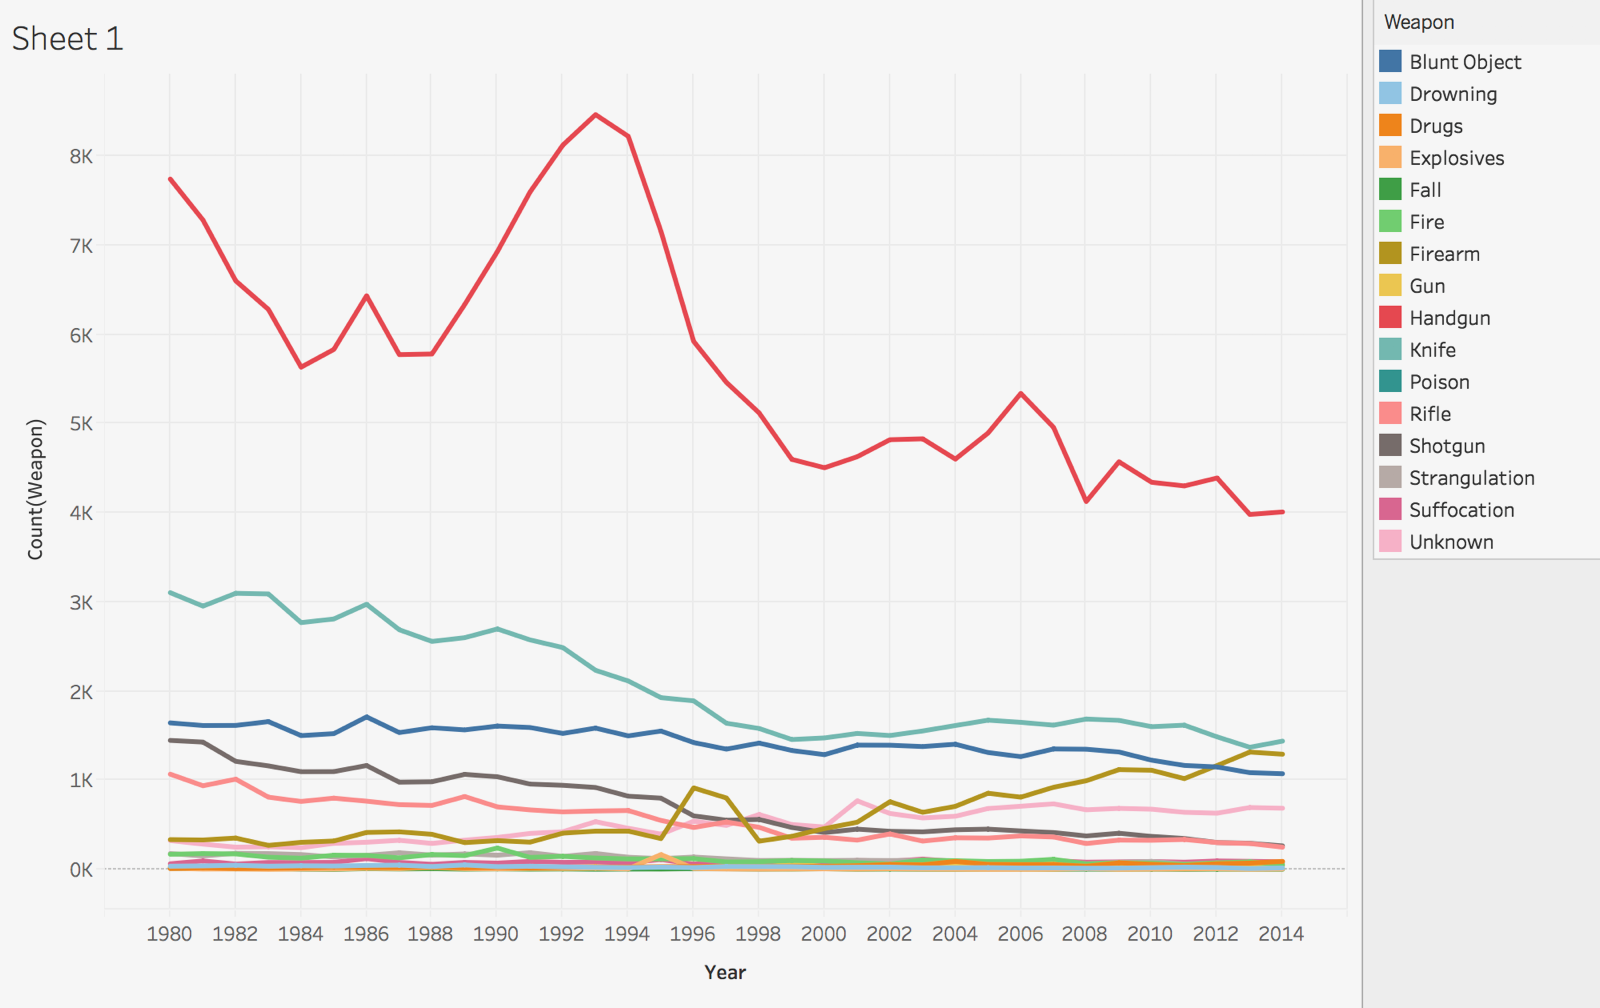

![](graphics/pic.png)

From the above graph and data, we can see that handgun is used most often for homicide. The rate of most weapon usage is reduce progressively year by year. However, there is one exception -- the usage rate of firearm is incredibly increasing.

## question 2 : 
Then we want to analyze the death count change over month and year. It would be interesting to find out that the death rates in some months are obviously higher than those of other months.


In [30]:
month=sqlc.sql("""
    select month, count(*) as month_count
    from dbb
    group by month
    order by month_count DESC
""")
month.show()

+---------+-----------+
|    month|month_count|
+---------+-----------+
|     July|      38853|
|   August|      38274|
|  January|      35775|
|      May|      35660|
|     June|      35480|
|September|      35455|
| December|      34861|
|  October|      34609|
|    March|      34598|
|    April|      34531|
| November|      31698|
| February|      31482|
+---------+-----------+



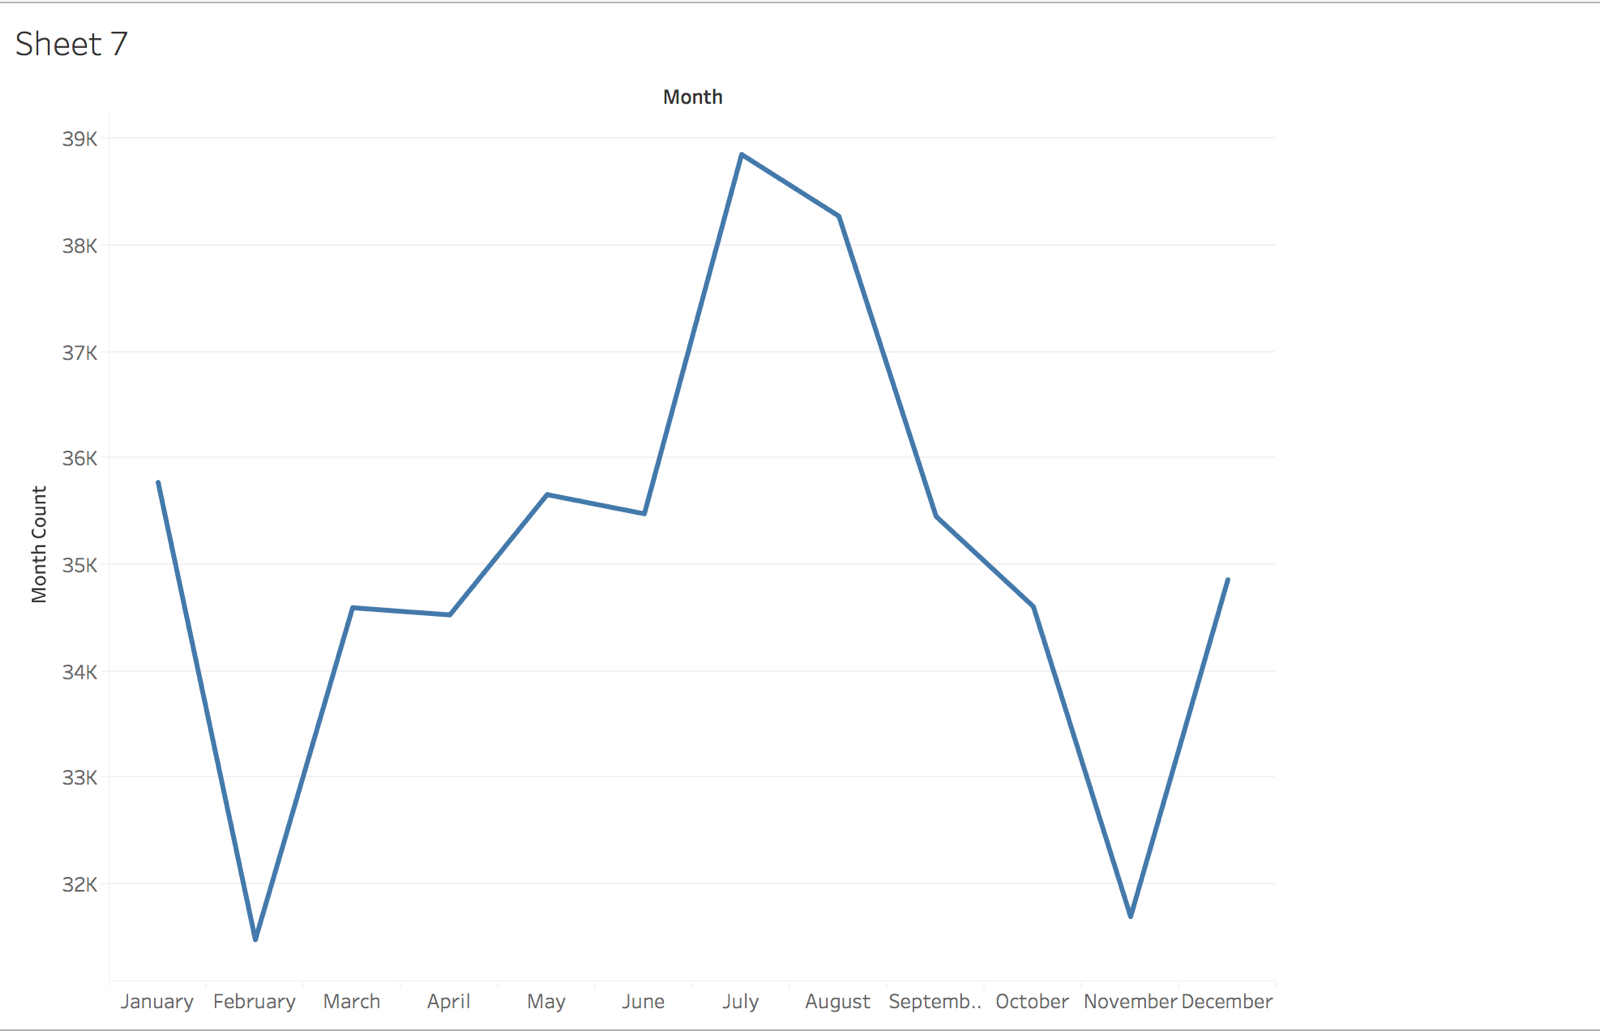

In [31]:
year=sqlc.sql("""
    select year, count(*) as year_count
    from dbb
    group by year
    order by year_count DESC
""")
year.show()

+----+----------+
|year|year_count|
+----+----------+
|1980|     16176|
|1981|     15365|
|1993|     15316|
|1992|     15029|
|1982|     14642|
|1994|     14614|
|1991|     14604|
|1986|     14310|
|1990|     14222|
|1983|     14003|
|1989|     13509|
|1995|     13325|
|1985|     13138|
|1987|     12951|
|1988|     12799|
|1984|     12762|
|1996|     12171|
|1997|     11220|
|2006|     10989|
|2007|     10812|
+----+----------+
only showing top 20 rows



In [32]:
year_change=year.toPandas()

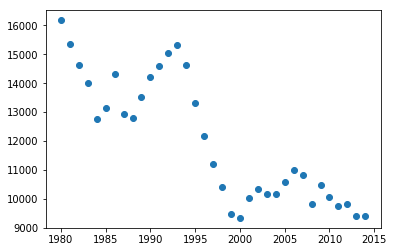

In [33]:
import matplotlib.pyplot as plt
year=year_change['year']
deathcount=year_change['year_count']
plt.plot(year,deathcount,'o')
plt.show()

As we expected, like handgun usage, death rate is in a general downward trend as year progresses. Something that surprised us is when we looked at the data for each month, there is a huge peak of homicide in the summer time. 

## question 3:
After considering death by time, we are going to check how different gender's perference for weapon for homicide, so that we can have a better idea that how to lower homicide rate by gender.


In [34]:
sqlc.sql("""
    select weapon, count(*)/(select count(*) from dbb where `Perpetrator Sex` = 'Male' group by `Perpetrator Sex`) as male_weapon
    from dbb
    where `Perpetrator Sex` = 'Male'
    group by weapon
    order by male_weapon DESC
""").show()

+-------------+--------------------+
|       weapon|         male_weapon|
+-------------+--------------------+
|      Handgun| 0.48920026791694576|
|        Knife|  0.1585103817816477|
| Blunt Object| 0.11882384460817147|
|      Shotgun| 0.06256128600133959|
|      Firearm| 0.05456932350971199|
|        Rifle|0.047177494976557266|
|      Unknown| 0.03724849296718018|
|Strangulation|0.010529135967849967|
|         Fire|0.008093770931011386|
|  Suffocation|0.005082384460817146|
|          Gun|0.002898861352980576|
|        Drugs|0.002143335565974...|
|     Drowning|0.001277963831212...|
|   Explosives|9.484259879437375E-4|
|       Poison|5.813797722705961E-4|
|         Fall|3.536503683858004E-4|
+-------------+--------------------+



In [35]:
sqlc.sql("""
    select weapon, count(*)/(select count(*) from dbb where `Perpetrator Sex` = 'Female' group by `Perpetrator Sex`) as female_weapon
    from dbb
    where `Perpetrator Sex` = 'Female'
    group by weapon
    order by female_weapon DESC
""").show()

+-------------+--------------------+
|       weapon|       female_weapon|
+-------------+--------------------+
|      Handgun|  0.3529907862278353|
|        Knife|    0.28524742246305|
| Blunt Object| 0.11729110881528179|
|      Unknown|  0.0743005334289148|
|      Shotgun| 0.03599063863880748|
|        Rifle|0.029939488498597903|
|      Firearm|0.025638322545278206|
|  Suffocation|0.021801007822218475|
|         Fire|0.020367285837778575|
|        Drugs|0.011786038077969175|
|     Drowning|0.010478820974509266|
|Strangulation| 0.00813848067637943|
|       Poison|0.003036117143519...|
|          Gun|0.001686731746399882|
|   Explosives|6.957768453899513E-4|
|         Fall|6.114402580699572E-4|
+-------------+--------------------+



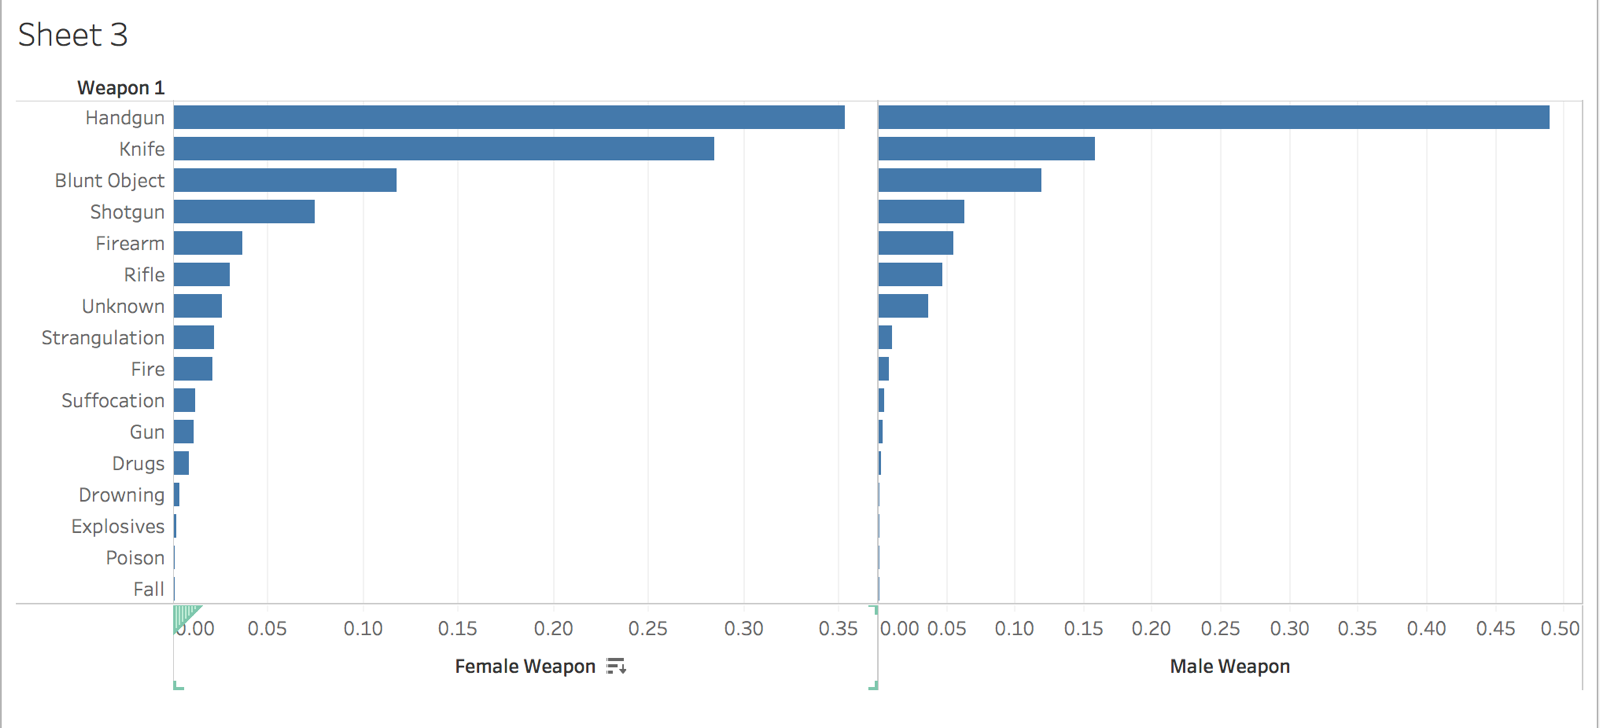

As we see above, even though there are more males like to use handguns comparing with females, the order of weapon usage is very similar for both genders. 

## Question 4: 
After considering different genders' weapon usage, we are going to take a look at different age's preferences for various weapons. We could have more understanding about who are more likely to commit.

In [36]:
sqlc.sql("""
    select `P_Age`,weapon,count(*) as age_weapon_prefer
    from dbb
    group by `P_Age`,weapon
    order by `P_Age`,age_weapon_prefer DESC
""").show()

+-----+-------------+-----------------+
|P_Age|       weapon|age_weapon_prefer|
+-----+-------------+-----------------+
|   11|      Handgun|               72|
|   11|        Rifle|               38|
|   11|      Shotgun|               32|
|   11| Blunt Object|               27|
|   11|        Knife|               25|
|   11|         Fire|               11|
|   11|      Unknown|                8|
|   11|      Firearm|                6|
|   11|  Suffocation|                3|
|   11|          Gun|                3|
|   11|Strangulation|                2|
|   12|      Handgun|              196|
|   12| Blunt Object|               59|
|   12|        Rifle|               59|
|   12|      Shotgun|               55|
|   12|        Knife|               50|
|   12|         Fire|               21|
|   12|      Firearm|               19|
|   12|      Unknown|               10|
|   12|  Suffocation|                6|
+-----+-------------+-----------------+
only showing top 20 rows



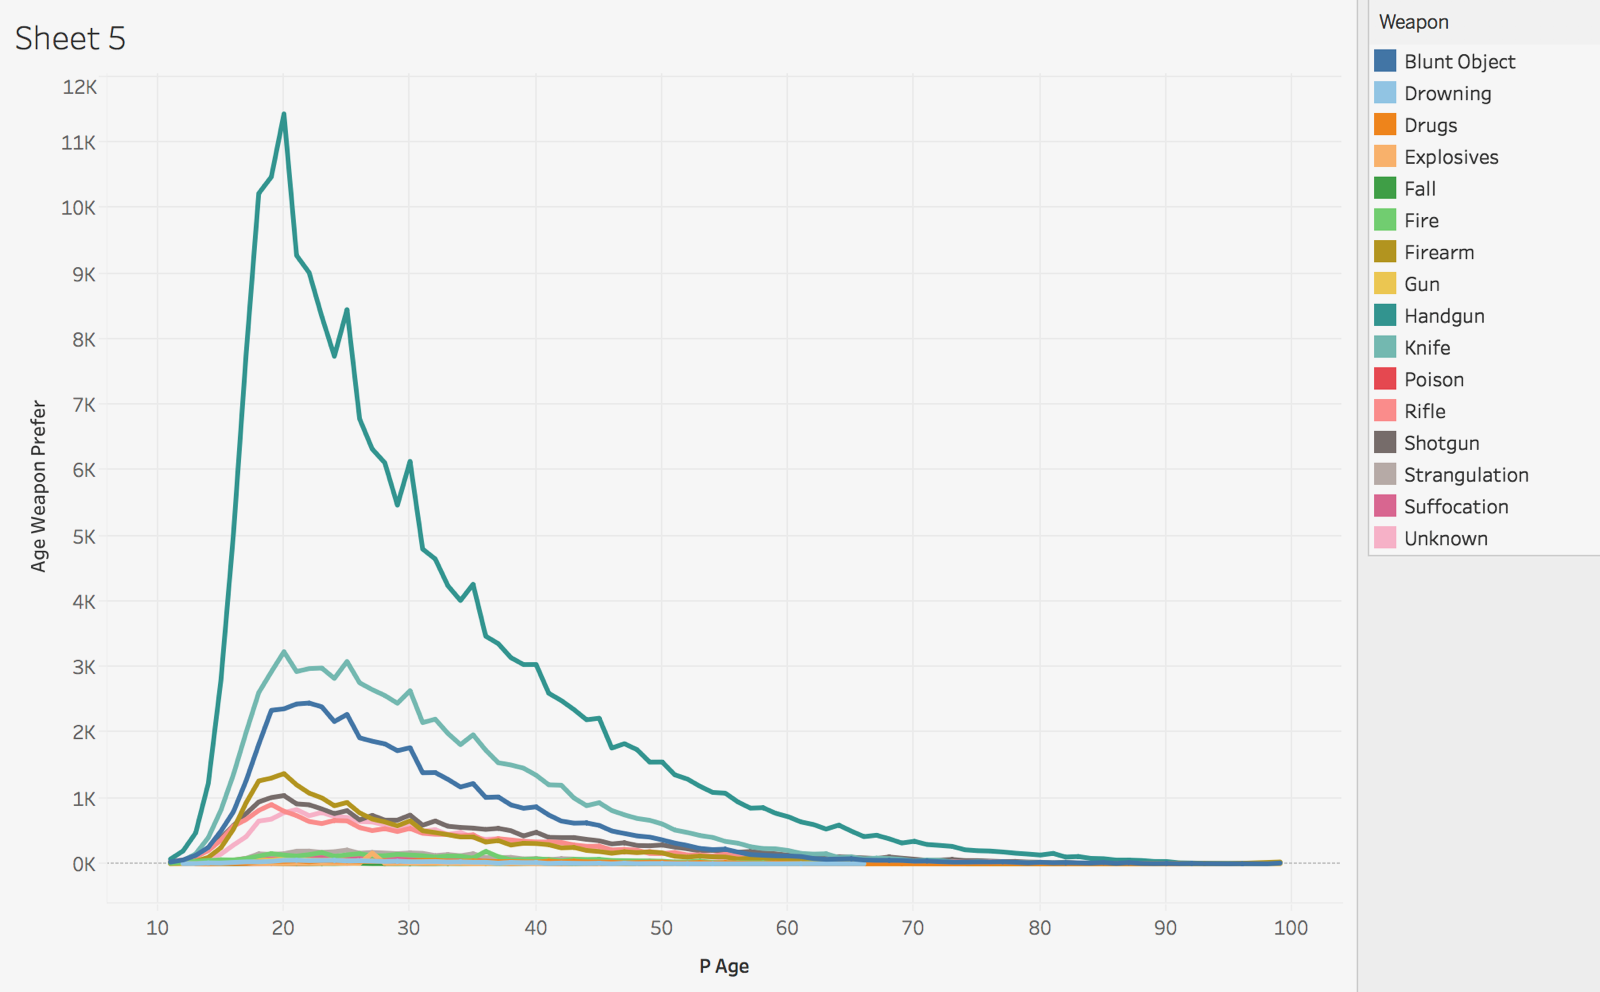

From the image above, if we add up the line, we can find out that the age of most of the perpetrator in these records are between 16 and 40. Among all the weapons perpetrator use, handgun has the greatest variation. The frequency of using handgun raise dramatically from 16 to 20, so we should pay more attention to juvenile delinquency.

## Question 5
Then we want to look at the relationship between perpetrator and victim. This will help us understand if different relationship will be a factor for the intention of perpetrator. 

In [37]:
sqlc.sql("""
    select year,relationship,count(*) as relationship_year
    from dbb
    group by year,relationship
    order by year,relationship_year DESC
""").show()

+----+------------------+-----------------+
|year|      relationship|relationship_year|
+----+------------------+-----------------+
|1980|      Acquaintance|             5287|
|1980|          Stranger|             3065|
|1980|           Unknown|             2303|
|1980|              Wife|              900|
|1980|            Friend|              802|
|1980|           Husband|              619|
|1980|        Girlfriend|              385|
|1980|          Neighbor|              318|
|1980|            Family|              296|
|1980|               Son|              283|
|1980|         Boyfriend|              283|
|1980|           Brother|              242|
|1980|            In-Law|              233|
|1980|          Daughter|              207|
|1980|            Father|              175|
|1980|Common-Law Husband|              164|
|1980|   Common-Law Wife|              126|
|1980|            Mother|              122|
|1980|           Ex-Wife|               73|
|1980|        Stepfather|       

As we can see above, the relationship between victim and perpetrator varies a lot. In order to do a better analysis, we are going to group some of them together. We are going to group all the data into six different catigories including, family, in a romantic relationship, divorced family, acquaintances, strangers, and employment. 

In [38]:
sqlc.sql("""
    select year,'family',count(*) as count
    from dbb
    where relationship in ('Husband','Wife','Son','Daughter','Father','Mother','Family','Brother','In-Law','Sisiter')
    group by year
    order by year
""").show()

+----+------+-----+
|year|family|count|
+----+------+-----+
|1980|family| 3077|
|1981|family| 3021|
|1982|family| 2920|
|1983|family| 2916|
|1984|family| 2568|
|1985|family| 2688|
|1986|family| 2736|
|1987|family| 2602|
|1988|family| 2382|
|1989|family| 2408|
|1990|family| 2338|
|1991|family| 2416|
|1992|family| 2360|
|1993|family| 2332|
|1994|family| 2204|
|1995|family| 2095|
|1996|family| 1927|
|1997|family| 1888|
|1998|family| 1803|
|1999|family| 1730|
+----+------+-----+
only showing top 20 rows



In [39]:
sqlc.sql("""
    select year,'relation',count(*) as count
    from dbb
    where relationship in ('Boyfriend','Girlfriend','Boyfriend/Girlfriend','Common-Law Husband','Common-Law Wife')
    group by year
    order by year
""").show()

+----+--------+-----+
|year|relation|count|
+----+--------+-----+
|1980|relation|  995|
|1981|relation|  946|
|1982|relation|  953|
|1983|relation|  985|
|1984|relation|  952|
|1985|relation|  912|
|1986|relation| 1007|
|1987|relation|  902|
|1988|relation|  926|
|1989|relation|  973|
|1990|relation|  904|
|1991|relation|  914|
|1992|relation| 1005|
|1993|relation| 1082|
|1994|relation|  986|
|1995|relation|  856|
|1996|relation|  753|
|1997|relation|  737|
|1998|relation|  757|
|1999|relation|  697|
+----+--------+-----+
only showing top 20 rows



In [40]:
sqlc.sql("""
    select year,'divorce',count(*) as count
    from dbb
    where relationship in ('Ex-Wife','Ex-Husband','Stepdaughter','Stepmother','Stepson','Stepfather')
    group by year
    order by year
""").show()

+----+-------+-----+
|year|divorce|count|
+----+-------+-----+
|1980|divorce|  262|
|1981|divorce|  265|
|1982|divorce|  273|
|1983|divorce|  247|
|1984|divorce|  229|
|1985|divorce|  232|
|1986|divorce|  245|
|1987|divorce|  203|
|1988|divorce|  189|
|1989|divorce|  180|
|1990|divorce|  212|
|1991|divorce|  162|
|1992|divorce|  186|
|1993|divorce|  203|
|1994|divorce|  192|
|1995|divorce|  148|
|1996|divorce|  140|
|1997|divorce|  153|
|1998|divorce|  143|
|1999|divorce|  131|
+----+-------+-----+
only showing top 20 rows



In [41]:
sqlc.sql("""
    select year,'acquaintance',count(*) as count
    from dbb
    where relationship in ('Acquaintance','Friend','Neighbor')
    group by year
    order by year
""").show()

+----+------------+-----+
|year|acquaintance|count|
+----+------------+-----+
|1980|acquaintance| 6407|
|1981|acquaintance| 6265|
|1982|acquaintance| 5916|
|1983|acquaintance| 5673|
|1984|acquaintance| 5340|
|1985|acquaintance| 5613|
|1986|acquaintance| 6149|
|1987|acquaintance| 5659|
|1988|acquaintance| 5412|
|1989|acquaintance| 5809|
|1990|acquaintance| 6028|
|1991|acquaintance| 5620|
|1992|acquaintance| 5550|
|1993|acquaintance| 5665|
|1994|acquaintance| 5406|
|1995|acquaintance| 4770|
|1996|acquaintance| 4341|
|1997|acquaintance| 4026|
|1998|acquaintance| 3525|
|1999|acquaintance| 3167|
+----+------------+-----+
only showing top 20 rows



In [42]:
sqlc.sql("""
    select year,'stranger',count(*) as count
    from dbb
    where relationship in ('Stranger')
    group by year
    order by year
""").show()

+----+--------+-----+
|year|stranger|count|
+----+--------+-----+
|1980|stranger| 3065|
|1981|stranger| 3003|
|1982|stranger| 2853|
|1983|stranger| 2532|
|1984|stranger| 2342|
|1985|stranger| 2251|
|1986|stranger| 2261|
|1987|stranger| 2085|
|1988|stranger| 2166|
|1989|stranger| 2435|
|1990|stranger| 2842|
|1991|stranger| 3235|
|1992|stranger| 3082|
|1993|stranger| 3294|
|1994|stranger| 2929|
|1995|stranger| 2886|
|1996|stranger| 2302|
|1997|stranger| 2037|
|1998|stranger| 1877|
|1999|stranger| 1607|
+----+--------+-----+
only showing top 20 rows



In [43]:
sqlc.sql("""
    select year,'employment',count(*) as count
    from dbb
    where relationship in ('Employer','Employee')
    group by year
    order by year
""").show()

+----+----------+-----+
|year|employment|count|
+----+----------+-----+
|1980|employment|   20|
|1981|employment|   30|
|1982|employment|   34|
|1983|employment|   32|
|1984|employment|   31|
|1985|employment|   44|
|1986|employment|   28|
|1987|employment|   31|
|1988|employment|   32|
|1989|employment|   29|
|1990|employment|   36|
|1991|employment|   26|
|1992|employment|   32|
|1993|employment|   44|
|1994|employment|   21|
|1995|employment|   26|
|1996|employment|   18|
|1997|employment|   18|
|1998|employment|   29|
|1999|employment|   25|
+----+----------+-----+
only showing top 20 rows



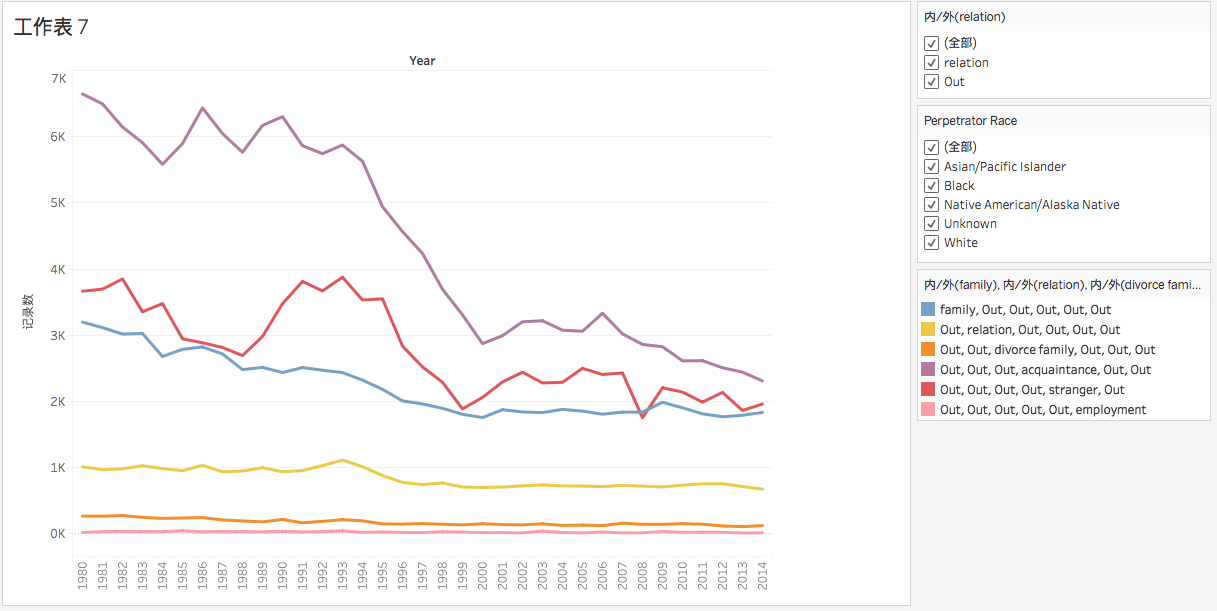

As we can see from the visialization, most incidents happen between acquaintances, and the rate of homicide between acquaintances has a general downward trend. 

## Question 6
Last but not least, we are going to look at victim and perpetrator's age distribution, so that we might could give some suggestions to the government that which groups of people they should pay attention to.

In [44]:
sqlc.sql("""
    select `Victim Age`,`P_Age`,count(*) as count
    from dbb
    group by `Victim Age`,`P_Age`
    order by count DESC
""").show()

+----------+-----+-----+
|Victim Age|P_Age|count|
+----------+-----+-----+
|        19|   19| 1700|
|        20|   20| 1661|
|        18|   18| 1619|
|        19|   20| 1388|
|        19|   18| 1346|
|        20|   19| 1342|
|        21|   21| 1342|
|        22|   22| 1277|
|        18|   19| 1251|
|        21|   20| 1249|
|        17|   17| 1206|
|        22|   20| 1184|
|        23|   23| 1167|
|        20|   21| 1125|
|        17|   18| 1122|
|        25|   25| 1118|
|        24|   24| 1093|
|        20|   18| 1091|
|        21|   19| 1087|
|        18|   20| 1083|
+----------+-----+-----+
only showing top 20 rows



From the above table, we can see that most incidents happen for people around age 20. People tend to perfrom violent actions towards others with similar age. This conclusion suggest us to focus on teenager and young adults.

## Conclusion:
As we can see from the visualization and analysis, there is an obvious relationship between homicide and age. About 2/3 perpetrators are between 18 - 30 years old. And most of them are only around 20 years old. There is also an relationship between weapon usage and homicide rate. Even though the rate of homicide is decling by year, but the percentage of handgun usage for homicide has been the highest through out the years. 

## Bonus

This dataset is from the General Social Survey (GSS). It shows the percentage of gun ownership from 1973 to 2016. 

In [45]:
!csvstat owngunn.csv

  1. year
	<class 'int'>
	Nulls: False
	Min: 1973
	Max: 2016
	Sum: 51829
	Mean: 1993.423076923077
	Median: 1992.0
	Standard Deviation: 12.59784193033772
	Unique values: 26
  2. total
	<class 'str'>
	Nulls: False
	Unique values: 24
	5 most frequent values:
		34.40%:	2
		32.40%:	2
		49.70%:	1
		48.90%:	1
		34.30%:	1
	Max length: 6

Row count: 26


In [46]:
owngun = sqlc.read.csv('owngunn.csv', header = True, inferSchema = True)

In [47]:
owngun.createOrReplaceTempView("owngun")

In [48]:
sqlc.sql("""
    SELECT * 
    FROM owngun
""").show()

+----+------+
|year| total|
+----+------+
|1973|49.10%|
|1974|47.80%|
|1976|49.70%|
|1977|53.90%|
|1980|50.80%|
|1982|48.80%|
|1984|48.40%|
|1985|48.10%|
|1987|48.60%|
|1988|43.40%|
|1989|48.90%|
|1990|45.80%|
|1991|43.70%|
|1993|45.50%|
|1994|43.90%|
|1996|43.30%|
|1998|36.60%|
|2000|34.30%|
|2002|36.40%|
|2004|37.20%|
+----+------+
only showing top 20 rows



In [49]:
sqlc.sql("""
    SELECT year, total 
    FROM owngun
    where year is not null
    and total is not null 
    and year > 1979
    and year < 2015
    order by year asc
""").show()

+----+------+
|year| total|
+----+------+
|1980|50.80%|
|1982|48.80%|
|1984|48.40%|
|1985|48.10%|
|1987|48.60%|
|1988|43.40%|
|1989|48.90%|
|1990|45.80%|
|1991|43.70%|
|1993|45.50%|
|1994|43.90%|
|1996|43.30%|
|1998|36.60%|
|2000|34.30%|
|2002|36.40%|
|2004|37.20%|
|2006|34.40%|
|2008|35.90%|
|2010|32.10%|
|2012|34.40%|
+----+------+
only showing top 20 rows



The overall trend of percentage of gun ownership is decreasing by year.

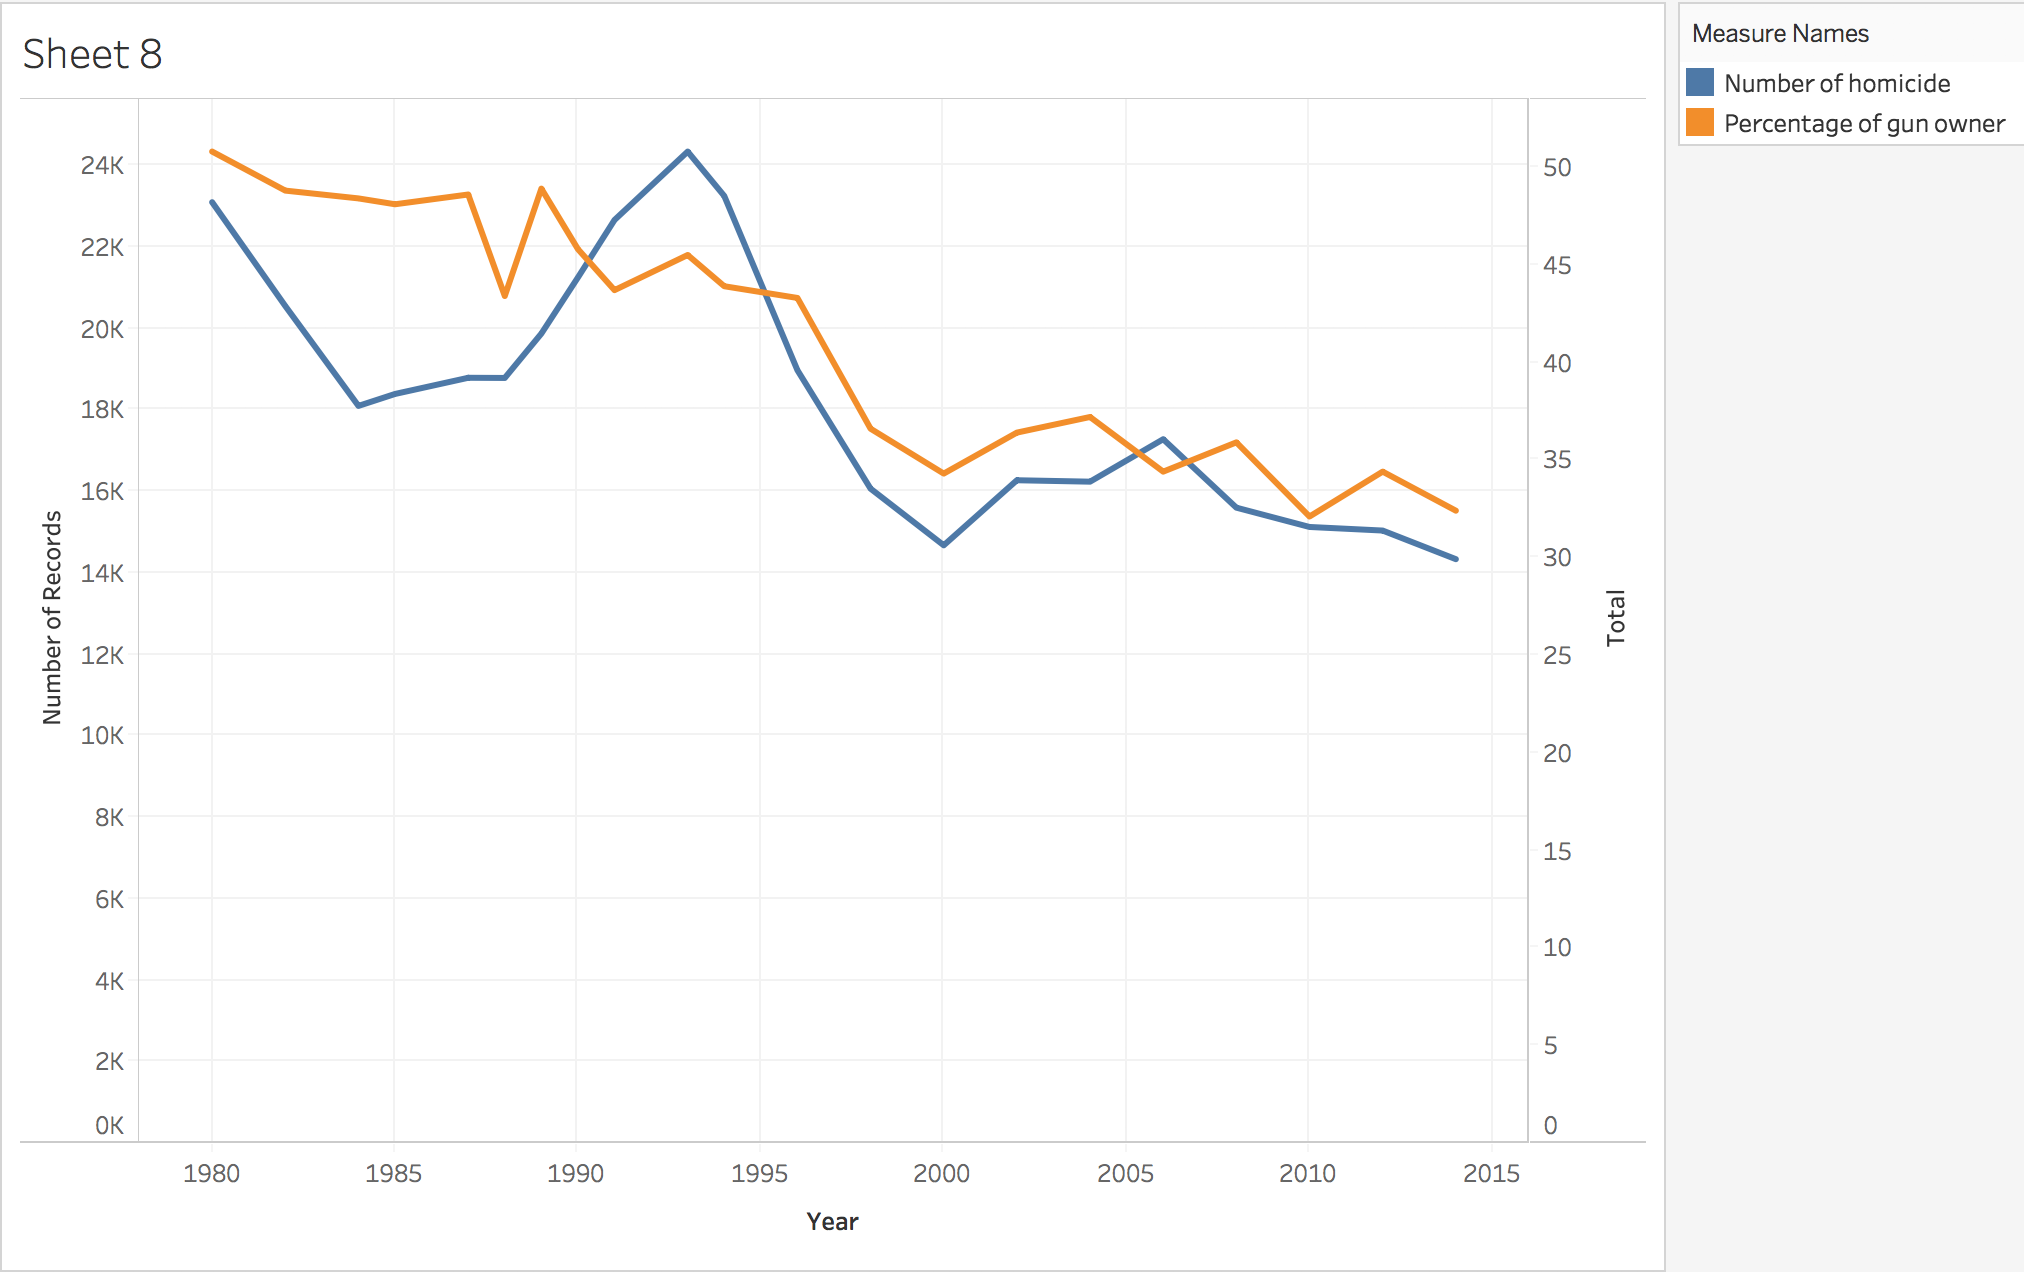

From the graph above, the orange one is percentage of gun ownership in the United States from 1980 to 2014. The blue one is the number of homicide records by year from 1980 to 2014. Both of them have a downward trend during this period.

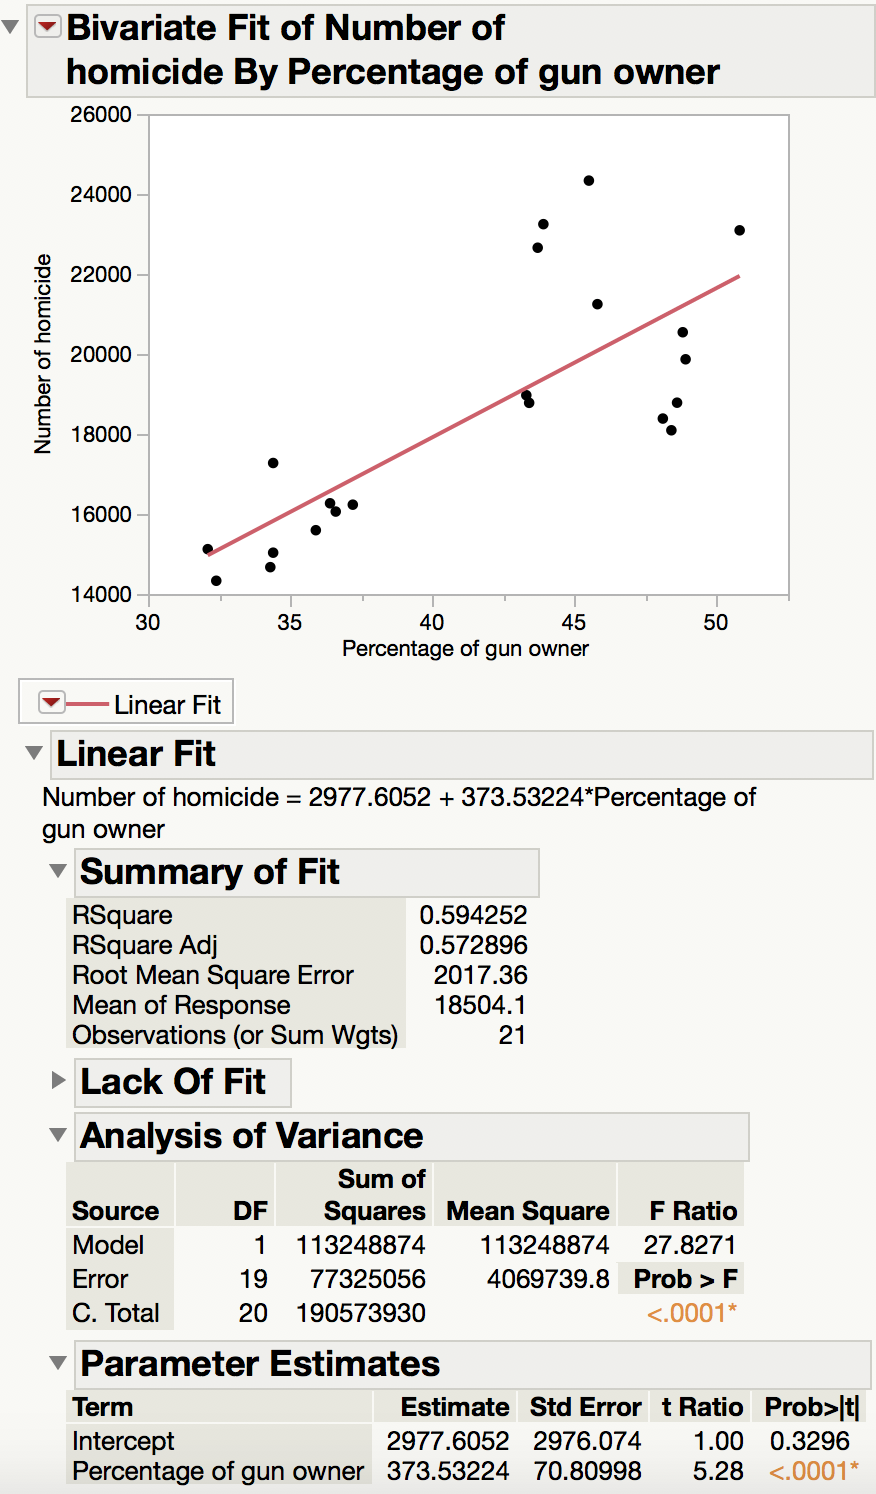

By running a regression on JMP PRO, we notice that the p value is much lower than the 0.05, which means that there is a relationship between number of homicide and percentage of gun ownership. The increase in percentage of gun ownership can increase the number of homicide. Therefore, controlling the gun might lower the homicide rate based on the result showed in the regression model.